# **Classifying Climate Change Tweets**

- Each tweet will be classified as either a "believer" tweet or "denier" tweet.
- This will be done by training a classifier model on a subset of tweets with definitive "believer" or "denier" hashtags. 
- Once the model has been trained, it will be used to classify the entire set of tweets. See below:

# Labeling Subset of Tweets

In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import emoji
import string
from collections import defaultdict
from sklearn.model_selection import train_test_split

import spacy
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler



from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
# from yellowbrick.classifier import DiscriminationThreshold
%matplotlib inline

## Read in `tweets_full_df`

- File is from "Project_04_Data_All_Tweets" notebook

In [2]:
with open('Data/tweets_full2_df.pkl','rb') as read_file:
    tweets_full_df = pickle.load(read_file)

In [3]:
tweets_full_df = tweets_full_df.sort_values(by='created_at').reset_index(drop=True)

In [4]:
tweets_full_df.head(5)

,created_at,favorite_count,full_text,geo,retweet_count,Hashtags_List,User_Name,User_Screen_Name,User_Status_Count,User_Followers_Count,User_Friends_Count,User_Verified_Status,User_Account_Start_Date,User_Years_Active,User_Location,Tweet_Location,Tweet_Location_Country,Tweet_Location_Country_Code
0,2017-09-21,0,"All #Hurricane victims should sue #Trump, #Pru...",NaN,0,"[Hurricane, Trump, Pruitt, FossilFuel, Climate...",Soledad Haren,Soledad_Haren,11511,317,260,False,2008-11-16,8.8,"New York, LA, Miami, Houston",NaN,NaN,NaN
1,2017-09-21,0,Liberals trying to stop #earthwindandfire in t...,NaN,0,"[earthwindandfire, climatechange]",Keith,Stonevoodo,21634,429,439,False,2011-12-14,5.8,NaN,NaN,NaN,NaN
2,2017-09-21,0,"@TwitterForGood Want to help the environment, ...",NaN,0,[],Urban Offsets,Urban_Offsets,1138,379,1810,False,2011-11-17,5.8,"Greensboro, NC",NaN,NaN,NaN
3,2017-09-21,0,Should be HUGE headlines. MSM: crickets https:...,NaN,0,[],President❌Vader,POTUS_NotSure,79834,1164,742,False,2009-06-18,8.3,Death Star,NaN,NaN,NaN
4,2017-09-21,2,Now @ICRAF presents how #trees reconstruct #cl...,NaN,1,"[trees, climatechange, rainfall, Africa, Fores...",Forests & Water,FoWaNetwork,2562,1162,888,False,2015-09-07,2.0,NaN,NaN,NaN,NaN


## Find definitive "believer" and "denier" hashtags

The hashtags below will be used as the definitive hashtags. The counts for these across the entire dataset can be found below in the `definitive_hashtags` dictionary.  There are many more believer tweets based on these hashtags.
- **Believer Hashtags**
    - #climatechangeisreal
    - #actonclimate
    - #extinctionrebellion
    - #climateemergency
    - #climateactionnow
- **Denier Hashtags**
    - #climatechangeisfalse
    - #climatechangenotreal
    - #climatechangehoax
    - #globalwarminghoax
    - #tcot
    - #ccot
    - #tlot
    - #pjnet
    - #rednationrising
    - #votered
    - #libtard
    - #libtards

In [5]:
# Remove capitalization from hashtags

hashtag_lower_pre = []
hashtag_collapse = [] # complete list of hashtags
hashtags_lower = [] # list of lists of hashtags for each tweet

for index, rows in tweets_full_df['Hashtags_List'].iteritems():
    hashtag_lower_pre = []
    for i in rows:
        i = i.lower()
        hashtag_collapse.append(i)
        hashtag_lower_pre.append(i)
    hashtags_lower.append(hashtag_lower_pre)

In [6]:
tweets_full_df['Hashtags_List'] = hashtags_lower

In [7]:
subtweets_dict = defaultdict(list)
subtweets_df = tweets_full_df[['full_text', 'Hashtags_List']]

In [8]:
# Manual check for how definitive these hashtags are:

# for index, rows in subtweets_df.iterrows():
#     if 'liberalismisamentaldisorder' in rows['Hashtags_List']:
#         subtweets_dict['liberalismisamentaldisorder'].append(rows['full_text'])
#     elif 'junkscience' in rows['Hashtags_List']:
#         subtweets_dict['junkscience'].append(rows['full_text'])
#     elif 'climatehoax' in rows['Hashtags_List']:
#         subtweets_dict['climatehoax'].append(rows['full_text'])
#     elif 'coalisgood' in rows['Hashtags_List']:
#         subtweets_dict['coalisgood'].append(rows['full_text'])
#     elif 'democratshateamerica' in rows['Hashtags_List']:
#         subtweets_dict['democratshateamerica'].append(rows['full_text'])


In [9]:
# subtweets_dict['junkscience']

In [10]:
# Look at count of these hashtags in the set of tweets:

definitive_hashtags = {'climatechangeisreal': [],
                       'actonclimate': [],
                       'extinctionrebellion': [],
                       'climateemergency': [],
                       'climateactionnow': [],
#                        'uniteblue': [],
                       'climatechangeisfalse': [], 
                       'climatechangenotreal': [], 
#                        'climatehoax': [],
                       'climatechangehoax': [], 
                       'globalwarminghoax': [],
#                        'thereisnoclimatechange': [],
#                        'liberalismisamentaldisorder': [],
#                        'junkscience': [],
                       'tcot': [],
                       'ccot': [],
                       'tlot': [],
                       'pjnet': [],
                       'rednationrising': [],
#                        'maga': [],
#                        'coalisgood': [],
#                        'democratshateamerica': [],
                       'votered': [],
                       'libtard': [],
                       'libtards': []
                      }

In [11]:
hashtag_series = pd.Series(hashtag_collapse)
hashtag_count = hashtag_series.value_counts()

In [12]:
for keys, values in definitive_hashtags.items():
    definitive_hashtags[keys] = hashtag_count[keys]

In [13]:
definitive_hashtags

{'climatechangeisreal': 38923,
 'actonclimate': 57411,
 'extinctionrebellion': 14074,
 'climateemergency': 13739,
 'climateactionnow': 8390,
 'climatechangeisfalse': 3,
 'climatechangenotreal': 2,
 'climatechangehoax': 2358,
 'globalwarminghoax': 973,
 'tcot': 4672,
 'ccot': 604,
 'tlot': 1162,
 'pjnet': 622,
 'rednationrising': 45,
 'votered': 9,
 'libtard': 127,
 'libtards': 152}

## Label tweets as "believer" or "denier" based on hashtags above.
- "0" indicates believer tweet
- "1" indicates denier tweet

In [14]:
# believe_deny_list = []

# for index, rows in tweets_full_df['Hashtags_List'].iteritems():
#     for tag in list(definitive_hashtags):
#         if tag in list(definitive_hashtags)[:5]:
#             if tag in rows:
#                 believe_deny_list.append(0)
#                 continue
#             else:
#                 believe_deny_list.append(np.nan)
#                 continue
#         elif tag in list(definitive_hashtags)[5:]:
#             if tag in rows:
#                 believe_deny_list.append(1)
#                 continue
#             else:
#                 believe_deny_list.append(np.nan)
#                 continue

In [15]:
believe_deny_list = []

for index, rows in tweets_full_df['Hashtags_List'].iteritems():
    if 'climatechangeisfalse' in rows:
        believe_deny_list.append(1)
    elif 'climatechangenotreal' in rows:
        believe_deny_list.append(1)
    elif 'climatechangehoax' in rows:
        believe_deny_list.append(1)
    elif 'globalwarminghoax' in rows:
        believe_deny_list.append(1)
    elif 'tcot' in rows:
        believe_deny_list.append(1)
    elif 'ccot' in rows:
        believe_deny_list.append(1)
    elif 'tlot' in rows:
        believe_deny_list.append(1)
    elif 'pjnet' in rows:
        believe_deny_list.append(1)
    elif 'rednationrising' in rows:
        believe_deny_list.append(1)
    elif 'votered' in rows:
        believe_deny_list.append(1)
    elif 'libtard' in rows:
        believe_deny_list.append(1)
    elif 'libtards' in rows:
        believe_deny_list.append(1)
    elif 'climatechangeisreal' in rows:
        believe_deny_list.append(0)
    elif 'actonclimate' in rows:
        believe_deny_list.append(0)
    elif 'extinctionrebellion' in rows:
        believe_deny_list.append(0)
    elif 'climateemergency' in rows:
        believe_deny_list.append(0)
    elif 'climateactionnow' in rows:
        believe_deny_list.append(0)
    else:
        believe_deny_list.append(np.nan)

In [16]:
len(believe_deny_list)

4225416

In [17]:
tweets_full_df.insert(2, column='Believer_or_Denier', value = believe_deny_list)

In [18]:
tweets_full_df['Believer_or_Denier'].value_counts()

0.0    124471
1.0      8451
Name: Believer_or_Denier, dtype: int64

**Of the labeled subset of tweets, 94% are believer tweets and 6% are denier tweets.**

___

**Text Preprocessing (NOT USED)**

- *Tokenize tweets, i.e. split the raw text into the individual words*
- *Perform stemming so that words are cut down to their base form*
    - *e.g. makes meaning of laugh, laughs, laughing all the same*
    - *Reduces complexity by reducing number of unique words*
    - *SnowballStemmer was used because it's considered an improvement on PorterStemmer, but is still less aggressive than LancasterStemmer*

In [19]:
# stemmer = SnowballStemmer("english")

# processed_tweets_list = []

# for index, rows in tweets_clean_df['full_text'].iteritems():
#     token_rows = word_tokenize(rows)    \
# #            .correct() # tokenize and apply spell check
#     stem_tokens = ''
#     for word in token_rows: # stemming
#         stem_tokens = stem_tokens + stemmer.stem(word) + ' '
#     processed_tweets_list.append(stem_tokens)

In [20]:
# tweets_clean_df.insert(4, column='tokenized_text', value = processed_tweets_list)

**Save Updated File as Pickle File**

In [21]:
# with open('tweets_clean2_df.pkl', 'wb') as to_write:
#     pickle.dump(tweets_clean_df, to_write)

In [22]:
# with open('Data/tweets_clean2_df.pkl','rb') as read_file:
#     tweets_clean_df = pickle.load(read_file)

___

# Build Classifier Model

- First, extract target variable and features (tweet text) from `tweets_full_df`
- Split full set into training and test sets
- Use CountVectorizer and TF-IDF to evaluate document similarity, i.e. find which tweets are similar and what similarities they share. They will output sparse matrix.
    - create and implement custom preprocessor
        - Remove the following characteristics from each tweet:
            - line breaks
            - URL's
            - numbers
            - capital letters
            - punctuation
    - create and implement custom tokenizer
        - splits tweets into individual words
        - lemmatizes words, i.e. cuts each word down to its base form
            - e.g. makes meaning of laugh, laughs, laughing all the same
            - Reduces complexity by reducing number of unique words
    - hashtags will need to be added as stop words
        - including them in the text could introduce data leakage
- Then, run the sparse matrix through a pipeline of different baseline models and evaluate which model types show the most promise based on precision, recall, and F1 score performance metrics.
- Perform further evaluation with confusion matrix, ROC curve, and precision/recall curve

## Create `classified_df`, split into training and test sets
- Composed of target (Believer_or_Denier classification) and feature (full_text)

In [23]:
classified_df = tweets_full_df[['Believer_or_Denier', 'full_text']]

In [24]:
classified_df = classified_df.dropna().reset_index(drop=True)

In [25]:
classified_df.tail(10)

,Believer_or_Denier,full_text
132912,0.0,@MikeHudema: 'Companies are now harnessing the...
132913,0.0,"Climate crisis it is, from now on.....#Climate..."
132914,0.0,GretaThunberg: RT GretaThunberg: Great news!! ...
132915,0.0,RT GretaThunberg: RT GretaThunberg: Great news...
132916,0.0,"""I used to think that top environmental proble..."
132917,0.0,The media are complacent while the world burns...
132918,0.0,The time to act is now. The costs of inaction ...
132919,0.0,"Write emails, start boycotting, divest in your..."
132920,0.0,A change of climate in the media? #ClimateChan...
132921,1.0,@EcoSenseNow This is the environmental action ...


In [26]:
# X = features, y = target

X = classified_df.full_text
y = classified_df.Believer_or_Denier

In [27]:
# stratify so percentage split remains 94%/6%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Create custom preprocessor and tokenizer
- These will be used as hyperparameters when running `CountVectorizer` and `TfidfVectorizer`

In [28]:
def tweet_preprocessor(tweet):

    '''
    Takes in tweet and cleans it by removing line breaks,
    URL's, emojis, numbers, capital letters, and punctuation.
    '''

    tweet = tweet.replace('\n', ' ') # remove line breaks
    tweet = re.sub(r"\bhttps://t.co/\w+", '', tweet) # remove URL's
    tweet = re.sub('\w*\d\w*', ' ', tweet) # remove numbers
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet.lower()) # remove capital letters and punctuation
    
    return tweet

In [29]:
# create a spaCy tokenizer
spacy.load('en')
lemmatizer = spacy.lang.en.English()

def tweet_tokenizer(doc):
    
    '''
    Takes in tweet, tokenizes words, then lemmatizes tokens
    '''
    
    tokens = lemmatizer(doc)
    return [token.lemma_ for token in tokens]

## Create list of stop words to be added
- Another hyperparameter that will be used when running `CountVectorizer` and `TfidfVectorizer`

In [30]:
# add hashtags as stop words

add_stop_words = list(definitive_hashtags)

In [31]:
new_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

## Vectorizer and Model Pipeline

We want to try out a number of different options. To compile them all and easily view the results, the different vectorizers and models will be run through a pipeline. The following vectorizers will be used (with a couple different variations on the hyperparameters):
- **CountVectorizer**
- **TfidfVectorizer**

And the following models will be used (these are baseline models; hyperparameters will be tuned later on):
- **Logistic Regression**
- **Naive Bayes**
- **Linear SVM**
- **Decision Trees**
- **XGBoost**

### Performance Metric Definitions

Precision, Recall, and F1 score will be looked at to evaluate our results. See below for an outline of the possible outcomes, and what different results mean for the business case:

#### Possible Outcomes

- **True Positive**: Predict user is a climate change denier, and they are a denier
- **False Positive (Type I Error)**: Predict user is a climate change denier, but they are a believer
- **True Negative**: Predict user is a climate change believer, and they are a believer
- **False Negative (Type II Error)**: Predict user is a climate change believer, but they are a denier

#### Metric Analysis

- **High Recall**: Most deniers were correctly predicted
    - No concern for number of users who were incorrectly predicted as deniers
- **High Precision**: Among the predictions of deniers, most predictions are correct
    - No concern for number of missed deniers

### Pipeline

In [32]:
class_results_dict = defaultdict(list)

In [33]:
vectorizer_dict = {'CV_1': CountVectorizer(max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=new_stop_words),
                   'CV_2': CountVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=new_stop_words),
                   'CV_3': CountVectorizer(ngram_range=(2,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=new_stop_words),
                   'TF_1': TfidfVectorizer(max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=new_stop_words),
                   'TF_2': TfidfVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=new_stop_words),
                   'TF_3': TfidfVectorizer(ngram_range=(2,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=new_stop_words),}


In [34]:
model_dict = {'Logistic Regression': LogisticRegression(max_iter=1000),    \
              'Naive Bayes': MultinomialNB(),    \
              'LinearSVM': SGDClassifier(random_state=42),    \
#               'Non-linear SVM': SVC(gamma="scale"),    \
#               'Neural Network': MLPClassifier(),    \
              'Decision Tree': DecisionTreeClassifier(max_depth=6),    \
              'XGBoost': XGBClassifier(max_depth=6)
             }

In [35]:
for vec_name, vectorizer in vectorizer_dict.items():
    
    X_train_cv = vectorizer.fit_transform(X_train)
    X_test_cv  = vectorizer.transform(X_test)
    print(vec_name) # keep track of progress
    
    for mod_name, model in model_dict.items():
        model.fit(X_train_cv, y_train);
        y_pred_cv = model.predict(X_test_cv)

        precision_cv = round(100*precision_score(y_test, y_pred_cv),3)
        recall_cv = round(100*recall_score(y_test, y_pred_cv),3)
        f1_cv = round(2 * (precision_cv * recall_cv) / (precision_cv + recall_cv),3)
        
        class_results_dict['Vectorizer Type'].append(vec_name)
        class_results_dict['Model Name'].append(mod_name)
        class_results_dict[('Precision')].append(precision_cv)
        class_results_dict[('Recall')].append(recall_cv)
        class_results_dict[('F1-score')].append(f1_cv)

class_results_df = pd.DataFrame(class_results_dict)

CV_1
CV_2
CV_3
TF_1
TF_2
TF_3


### Pipeline with Cross-Validation

In [36]:
# # X = features, y = target

# X_train = classified_df.full_text
# y_train = classified_df.Believer_or_Denier

In [37]:
# for vec_name, vectorizer in vectorizer_dict.items():
    
#     X_train_cv = vectorizer.fit_transform(X_train)
#     print(vec_name)
    
#     for mod_name, model in model_dict.items():
        
#         model.fit(X_train_cv, y_train);
#         y_pred_cv = cross_val_predict(model, X_train_cv, y_train, cv=5)

#         precision_cv = round(100*precision_score(y_train, y_pred_cv),3)
#         recall_cv = round(100*recall_score(y_train, y_pred_cv),3)
#         f1_cv = round(100*f1_score(y_train, y_pred_cv),3)
        
#         class_results_dict['Vectorizer Type'].append(vec_name)
#         class_results_dict['Model Name'].append(mod_name)
#         class_results_dict[('Precision')].append(precision_cv)
#         class_results_dict[('Recall')].append(recall_cv)
#         class_results_dict[('F1-score')].append(f1_cv)

# class_results_df = pd.DataFrame(class_results_dict)

#### Manual Cross-Validation

In [38]:
# skfolds = StratifiedKFold(n_splits=5, random_state=42)

# for vec_name, vectorizer in vectorizer_dict.items():
    
#     X_train_cv = vectorizer.fit_transform(X_train)
    
#     for mod_name, model in model_dict.items():
        
#         metric_dict = defaultdict(list)
        
#         for train_index, test_index in skfolds.split(X_train, y_train):
#             clone_model = clone(model)
#             X_train_folds, y_train_folds = X_train[train_index], y_train[train_index]
#             X_test_fold, y_test_fold = X_train[test_index], y_train[test_index]

#             clone_model.fit(X_train_folds, y_train_folds)
#             y_pred = clone_model.predict(X_test_fold)
            
#             metric_dict['Precision'].append(round(100*precision_score(y_test_fold, y_pred),3))
#             metric_dict['Recall'].append(round(100*recall_score(y_test_fold, y_pred),3))
#             metric_dict['F1_Score'].append(round(100*f1_score(y_test_fold, y_pred),3))

#         precision_cv = np.mean(metric_dict['Precision'])
#         recall_cv = np.mean(metric_dict['Recall'])
#         f1_cv = np.mean(metric_dict['F1_Score'])
        
#         class_results_dict['Vectorizer Type'].append(vec_name)
#         class_results_dict['Model Name'].append(mod_name)
#         class_results_dict[('Precision')].append(precision_cv)
#         class_results_dict[('Recall')].append(recall_cv)
#         class_results_dict[('F1-score')].append(f1_cv)

# class_results_df = pd.DataFrame(class_results_dict)

### Pipeline - Oversampling with `RandomOverSampler`

- Because we are working with an imbalanced dataset, we will look at the effect of oversampling and compare it to the results generated above.

In [39]:
class_results_ros = defaultdict(list)

In [40]:
for vec_name, vectorizer in vectorizer_dict.items():
    
    X_train_cv = vectorizer.fit_transform(X_train)
    X_test_cv  = vectorizer.transform(X_test)
    X_train_ros, y_train_ros = RandomOverSampler(random_state=42).fit_sample(X_train_cv, y_train)
    
#     std.fit(X_train_ros.values)
#     X_tr_cv = std.transform(X_train_ros.values)
#     X_te_cv = std.transform(X_test_cv.values)
    
    print(vec_name) # keep track of progress
    
    for mod_name, model in model_dict.items():
        model.fit(X_train_ros, y_train_ros);
        y_pred_cv = model.predict(X_test_cv)

        precision_cv = round(100*precision_score(y_test, y_pred_cv),3)
        recall_cv = round(100*recall_score(y_test, y_pred_cv),3)
        f1_cv = round(2 * (precision_cv * recall_cv) / (precision_cv + recall_cv),3)
        
        class_results_ros['Vectorizer Type'].append(vec_name)
        class_results_ros['Model Name'].append(mod_name)
        class_results_ros[('Precision')].append(precision_cv)
        class_results_ros[('Recall')].append(recall_cv)
        class_results_ros[('F1-score')].append(f1_cv)

class_results_ros_df = pd.DataFrame(class_results_ros)

CV_1
CV_2
CV_3
TF_1
TF_2
TF_3


### Pipeline - Oversampling with `RandomOverSampler` and Cross-Validation

In [41]:
# for vec_name, vectorizer in vectorizer_dict.items():
    
#     X_train_cv = vectorizer.fit_transform(X_train)
#     X_train_ros, y_train_ros = RandomOverSampler(random_state=42).fit_sample(X_train_cv, y_train)
    
# #     std.fit(X_train_ros.values)
# #     X_tr_cv = std.transform(X_train_ros.values)
# #     X_te_cv = std.transform(X_test_cv.values)
    
#     print(vec_name) # keep track of progress
    
#     for mod_name, model in model_dict.items():
#         model.fit(X_train_ros, y_train_ros);
#         y_pred_cv = cross_val_predict(model, X_train_ros, y_train_ros, cv=5)

#         precision_cv = round(100*precision_score(y_train_ros, y_pred_cv),3)
#         recall_cv = round(100*recall_score(y_train_ros, y_pred_cv),3)
#         f1_cv = round(2 * (precision_cv * recall_cv) / (precision_cv + recall_cv),3)
        
#         class_results_ros['Vectorizer Type'].append(vec_name)
#         class_results_ros['Model Name'].append(mod_name)
#         class_results_ros[('Precision')].append(precision_cv)
#         class_results_ros[('Recall')].append(recall_cv)
#         class_results_ros[('F1-score')].append(f1_cv)

# class_results_ros_df = pd.DataFrame(class_results_ros)

## Performance Metric Evaluation

- F1 score is the best metric to look at, as it balances precision and recall. According to the results below, **CountVectorizer** with 1,2,3 ngrams is the ideal vectorizer in combination with either **Logistic Regression** or **LinearSVM** models.

In [42]:
# No oversampling

class_results_df.sort_values(by='F1-score', ascending=False).reset_index(drop=True)

,Vectorizer Type,Model Name,Precision,Recall,F1-score
0,CV_2,Logistic Regression,91.875,69.586,79.192
1,CV_2,LinearSVM,92.575,67.870,78.320
2,CV_3,Logistic Regression,93.863,64.260,76.290
3,CV_1,Logistic Regression,88.471,66.746,76.088
4,CV_3,LinearSVM,95.723,62.249,75.439
5,CV_1,Naive Bayes,66.789,75.680,70.957
6,CV_2,Naive Bayes,63.973,79.645,70.954
7,TF_2,Logistic Regression,95.816,55.562,70.337
8,TF_1,Logistic Regression,93.781,56.213,70.292
9,CV_1,LinearSVM,76.901,62.840,69.163


In [43]:
# RandomOverSampling

class_results_ros_df.sort_values(by='F1-score', ascending=False).reset_index(drop=True)

,Vectorizer Type,Model Name,Precision,Recall,F1-score
0,CV_2,Logistic Regression,76.358,78.166,77.251
1,CV_2,LinearSVM,75.624,78.935,77.244
2,TF_2,Logistic Regression,70.030,82.544,75.774
3,CV_3,Logistic Regression,73.433,75.562,74.482
4,CV_3,LinearSVM,73.116,75.799,74.433
5,TF_3,Logistic Regression,69.942,77.929,73.720
6,TF_2,LinearSVM,66.379,81.893,73.324
7,TF_3,LinearSVM,68.863,76.686,72.564
8,CV_1,Logistic Regression,60.411,81.716,69.467
9,TF_1,Logistic Regression,58.043,83.905,68.618


## Further Evaluation

- Looking at confusion matrix, ROC curve, and precision/recall curve for logistic regression and linearSVM models.
    - Because we are working with an imbalanced dataset, the ROC curve will not be used. It tends to be a little too optimistic.
    - Therefore, the precision-recall curve and confusion matrix will be evaluated.

In [44]:
# Confusion Matrix Function

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_believer', 'predicted_denier'], 
                yticklabels=['actual_beliver', 'actual_denier'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    return

In [45]:
# ROC Curve Function

def roc_curve_generator(X_test, y_test, model_name, model_variable):

    roc_curve_dict = defaultdict(list)
    
    fpr, tpr, thresholds = roc_curve(y_test, model_variable.predict_proba(X_test)[:,1])
    roc_curve_dict[model_name] = pd.DataFrame(list(zip(fpr, tpr, thresholds)),    \
                                              columns=['False Positive Rate','True Positive Rate', 'Threshhold'])
    
    # Plot roc_curve
    
    fig1 = plt.figure(figsize=[9,9], dpi=100)

    plt.plot(roc_curve_dict[model_name]['False Positive Rate'].values,    \
             roc_curve_dict[model_name]['True Positive Rate'].values,    \
             lw=2, label=model_name)

    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate', fontsize=15)
    plt.ylabel('True positive rate', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('ROC Curve', fontsize=15);
    plt.legend(fontsize=10)
    
    return roc_curve_dict

In [46]:
# Precision-Recall Curve Function

def prec_rec_curve_generator(X_test, y_test, model_name, model_variable):

    prec_rec_curve_dict = defaultdict(list)
    
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model_variable.decision_function(X_test))
    prec_rec_curve_dict[model_name] = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),    \
                                                   columns=['precision','recall','threshold'])

    # Plot precision_recall_curve
    
    fig2 = plt.figure(figsize=[9,9], dpi=100)

    plt.plot(prec_rec_curve_dict[model_name]['recall'].values,    \
             prec_rec_curve_dict[model_name]['precision'].values,    \
             lw=2, label=model_name)

    plt.plot([1,0],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Precision-Recall Curve', fontsize=15);
    plt.legend(fontsize=10)
    
    return prec_rec_curve_dict

In [47]:
# Set CountVectorizer to CV_2 from above

cv = CountVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=new_stop_words)

X_train_cv2 = cv.fit_transform(X_train)
X_test_cv2  = cv.transform(X_test)
X_train_ros, y_train_ros = RandomOverSampler(random_state=42).fit_sample(X_train_cv2, y_train)

### Logistic Regression

In [48]:
logit = LogisticRegression(max_iter=1000)

In [49]:
logit.fit(X_train_cv2, y_train)
y_pred_logit = logit.predict(X_test_cv2)

#### Confusion Matrix

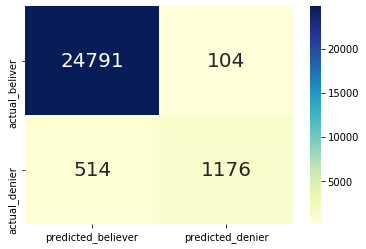

In [50]:
conf_matrix(y_test, y_pred_logit)

#### ROC Curve

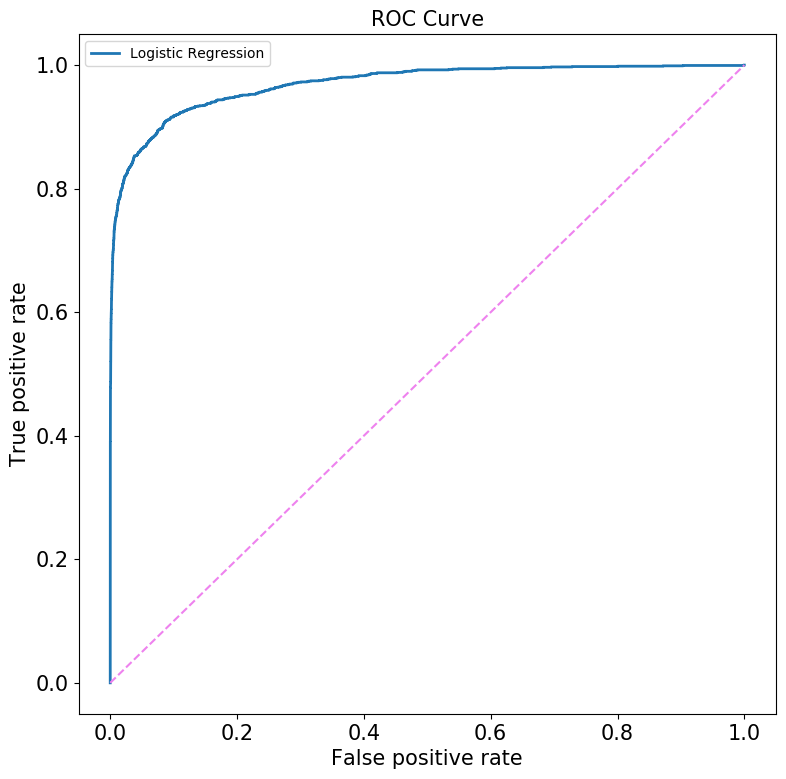

In [51]:
logit_roc = roc_curve_generator(X_test_cv2, y_test, 'Logistic Regression', logit)

#### Precision-Recall Curve
- Looks promising!

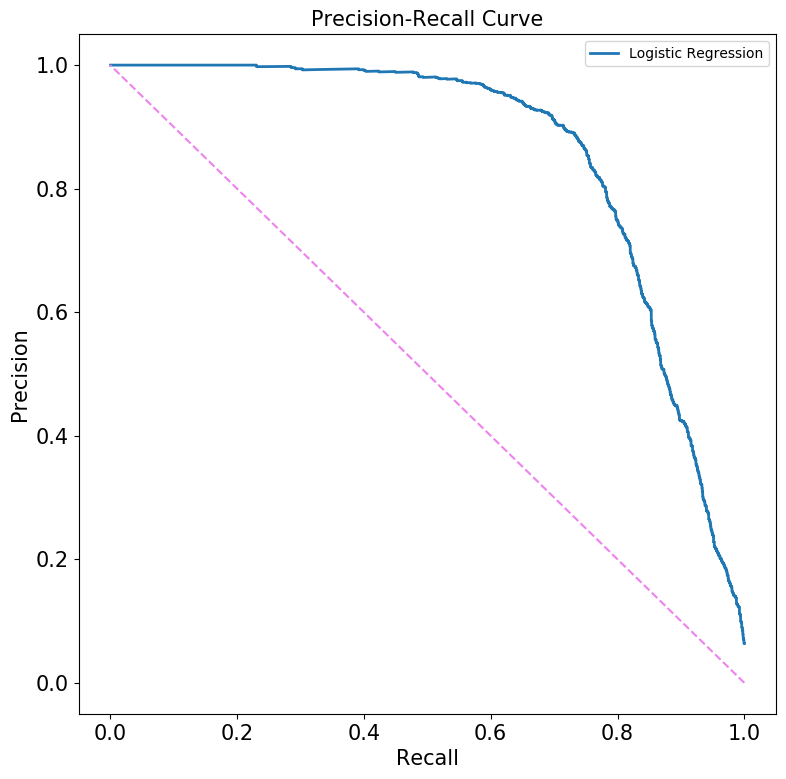

In [52]:
logit_prec_rec = prec_rec_curve_generator(X_test_cv2, y_test, 'Logistic Regression', logit)

### Linear SVM

In [53]:
svm = SGDClassifier()

In [54]:
svm.fit(X_train_cv2, y_train)
y_pred_svm = svm.predict(X_test_cv2)

In [55]:
# svc = SVC(probability=True)

In [56]:
# svc.fit(X_train_cv2, y_train)
# y_pred_svc = svc.predict(X_test_cv2)

#### Confusion Matrix

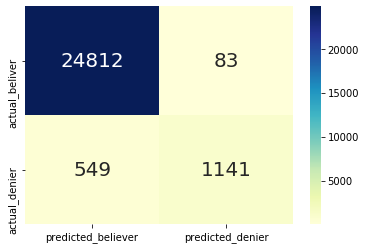

In [57]:
conf_matrix(y_test, y_pred_svm)

In [58]:
# conf_matrix(y_test, y_pred_svc)

#### ROC Curve

In [59]:
# roc_curve_generator(X_test_cv2, y_test, 'Linear SVM', svm)

#### Precision-Recall Curve
- Looks promising!

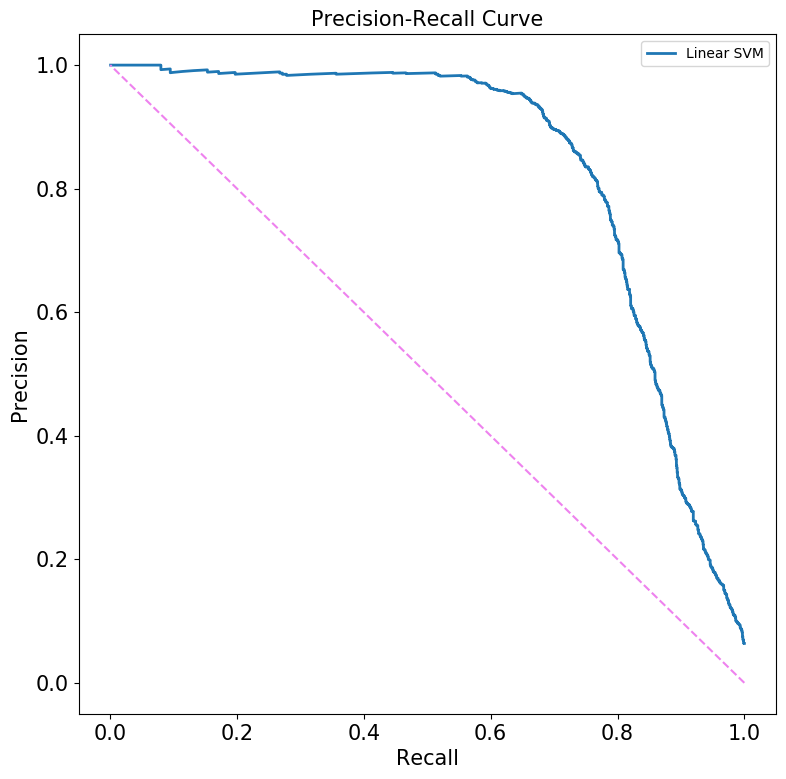

In [60]:
svm_prec_rec = prec_rec_curve_generator(X_test_cv2, y_test, 'Linear SVM', svm)

# Optimize Models with GridSearch

- With the two best baseline models selected, GridSearchCV will now be used to find the hyperparameters and threshold that optimize the F1 score for each.  The model that has the highest F1 score will be applied to the entire dataset.
    - The optimal threshold will be found using the confusion matrix widget.

## Logistic Regression GridSearch

In [61]:
# logit_params = [{'max_iter': [100000]}, {'penalty': ['none', 'l2']}, {'solver': ['lbfgs']}, {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}]

# gs_logit = GridSearchCV(LogisticRegression(), logit_params, cv=5, scoring='f1', error_score=0.0)
# gs_logit.fit(X_train_cv2, y_train)
# y_true, y_pred = y_test, gs_logit.predict(X_test_cv2)

# print('Best Parameters are:', gs_logit.best_params_)
# print('accuracy =', accuracy_score(y_true, y_pred))
# print('precision = ', precision_score(y_true, y_pred))
# print('recall = ', recall_score(y_true, y_pred))
# print('f1 score = ', f1_score(y_true, y_pred))


In [62]:
logit_gs = LogisticRegression(max_iter=1000, solver='lbfgs', penalty='l2', C=1)
logit_gs.fit(X_train_cv2, y_train)
y_true, y_pred = y_test, logit_gs.predict(X_test_cv2)

print('accuracy =', accuracy_score(y_true, y_pred))
print('precision = ', precision_score(y_true, y_pred))
print('recall = ', recall_score(y_true, y_pred))
print('f1 score = ', f1_score(y_true, y_pred))

accuracy = 0.9767538085386496
precision =  0.91875
recall =  0.6958579881656805
f1 score =  0.791919191919192


In [63]:
from ipywidgets import interact
# Create a widget to show confusion matrix and the precision and recall scores given a sliding threshold value as an input
@interact(thresh=(0, 1, .01))
def logit_confusion(thresh):
    y_predict = (logit_gs.predict_proba(X_test_cv2)[:, 1] > thresh)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = 2 * (precision * recall) / (precision + recall)
    logit_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(logit_confusion, cmap=plt.cm.Purples, annot=True, square=True, fmt='g',
           xticklabels=['Believer', 'Denier'],
           yticklabels=['Believer', 'Denier'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic Regression Confusion Matrix');
    
    return 'Threshold: ' + str(thresh), "Precision: {:6.4f},   Recall: {:6.4f},    F1-score: {:6.4f}".format(precision, recall, f1)

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

**Optimal Threshold: 0.32, Precision: 0.8697, Recall: 0.7462, F1-score: 0.8032**

## SVM GridSearch

In [64]:
# svm_params = [{'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], 'penalty': ['l1', 'l2'], 
#                  'alpha': [0.0001,0.001,0.01,0.1,1,10,100,1000], 'random_state': [42]}]

# gs_svm = GridSearchCV(SGDClassifier(), svm_params, cv=5, scoring='f1')
# gs_svm.fit(X_train_ros, y_train_ros)
# y_true, y_pred = y_test, gs_svm.predict(X_test_cv2)

# print('Best Parameters:', gs_svm.best_params_)
# print('accuracy =', accuracy_score(y_true, y_pred))
# print('precision = ', precision_score(y_true, y_pred))
# print('recall = ', recall_score(y_true, y_pred))
# print('f1 score = ', f1_score(y_true, y_pred))

In [65]:
svm = SGDClassifier(loss='modified_huber', penalty='l2', alpha=0.0001, random_state=42)
svm.fit(X_train_ros, y_train_ros)
y_true, y_pred = y_test, svm.predict(X_test_cv2)

print('accuracy =', accuracy_score(y_true, y_pred))
print('precision = ', precision_score(y_true, y_pred))
print('recall = ', recall_score(y_true, y_pred))
print('f1 score = ', f1_score(y_true, y_pred))

accuracy = 0.9703216099304118
precision =  0.7599538372763993
recall =  0.7792899408284024
f1 score =  0.7695004382120946


In [66]:
from ipywidgets import interact
# Create a widget to show confusion matrix and the precision and recall scores given a sliding threshold value as an input
@interact(thresh=(0, 1, .01))
def logit_confusion(thresh):
    y_predict = (svm.predict_proba(X_test_cv2)[:, 1] > thresh)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    fbeta = (precision*recall)/((1**2*precision+recall)/(1**2+1))
    logit_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(logit_confusion, cmap=plt.cm.Purples, annot=True, square=True, fmt='g',
           xticklabels=['Believer', 'Denier'],
           yticklabels=['Believer', 'Denier'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('SVM Confusion Matrix');
    
    return 'Threshold: ' + str(thresh), "Precision: {:6.4f},   Recall: {:6.4f},    F-beta: {:6.4f}".format(precision, recall, fbeta)

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

**Optimal Threshold: 0.67
Precision: 0.8775
Recall: 0.7166
F-beta: 0.7889**

## Apply Logistic Regression model to entire data set

- Logistic Regression was the best model with an F1 score of **0.803**
- The optimal threshold was 0.32
- It will be applied to the entire dataset

In [67]:
X_final_train = classified_df.full_text # all tweets in classified_df
y_final_train = classified_df.Believer_or_Denier # all tweets in classified_df

In [68]:
X_final_test = tweets_full_df[tweets_full_df['Believer_or_Denier'].isna()].full_text

In [69]:
cv_final = CountVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=new_stop_words)

In [70]:
X_final_train_cv = cv.fit_transform(X_final_train)
X_final_test_cv  = cv.transform(X_final_test)

In [71]:
logit_final = LogisticRegression(max_iter=1000, solver='lbfgs', penalty='l2', C=1, random_state=42)
logit_final.fit(X_final_train_cv, y_final_train)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
y_final_predict = logit_final.predict_proba(X_final_test_cv)

### Classify tweets using calculated prediction probabilities and optimal threshold

In [73]:
believer_denier_preds = []

for i in y_final_predict:
    if i[1] < 0.32:
        believer_denier_preds.append(0)
    else:
        believer_denier_preds.append(1)

### Create final classified dataframe (`tweets_classified_df`)

In [74]:
tweets_test_df = tweets_full_df[tweets_full_df['Believer_or_Denier'].isna()]
tweets_test_df['Believer_or_Denier'] = believer_denier_preds

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [75]:
pre_classified_df = tweets_full_df[tweets_full_df['Believer_or_Denier'].notnull()]

In [76]:
tweets_classified_df = tweets_test_df.append(pre_classified_df)
tweets_classified_df = tweets_classified_df.sort_values(by='created_at').reset_index(drop=True)


0.0    3806856
1.0     418560
Name: Believer_or_Denier, dtype: int64

In [79]:
with open('tweets_classified_logit.pkl', 'wb') as to_write:
    pickle.dump(tweets_classified_df, to_write)

### Check ratio of believer tweets to denier tweets

Is it similar to the ratio in the training set?

In [77]:
tweets_classified_df['Believer_or_Denier'].value_counts()

0.0    3806856
1.0     418560
Name: Believer_or_Denier, dtype: int64

In [78]:
418560/(418560+3806856)

0.09905770224754201

**90% believer tweets, 10% denier tweets**
- Similar to ratio in training set